[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/line_detection_and_matching_sold2.ipynb)

# Line detection and matching example with SOLD2: Self-supervised Occlusion-aware Line Description and Detection

In this tutorial we will show how we can quickly perform line detection, and matching using [`kornia.feature.sold2`](https://kornia.readthedocs.io/en/latest/feature.html#kornia.feature.SOLD2_detector) API.

## Setup

Install the libraries:

In [ ]:
%%capture
!pip install git+https://github.com/kornia/kornia
!pip install kornia-rs
!pip install opencv-python --upgrade # Just for windows
!pip install matplotlib

Now let's download an image

In [ ]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1].split("?")[0] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


download_image("https://github.com/cvg/SOLD2/raw/main/assets/images/terrace0.JPG")
download_image("https://github.com/cvg/SOLD2/raw/main/assets/images/terrace1.JPG")

'terrace1.JPG'

Then, we will load the libraries

In [ ]:
import kornia as K
import kornia.feature as KF
import torch

Load the images and convert into torch tensors.

In [ ]:
fname1 = "terrace0.JPG"
fname2 = "terrace1.JPG"

torch_img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32)[None, ...]
torch_img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32)[None, ...]

torch_img1.shape, torch_img2.shape

(torch.Size([1, 3, 496, 744]), torch.Size([1, 3, 496, 744]))

Prepare the data for the model, which is expected a batch of images in gray scale (shape: (Batch size, 1, Height, Width)).

The SOLD2 model was tuned for images in the range 400~800px when using `config=None`.

In [ ]:
# First, convert the images to gray scale
torch_img1_gray = K.color.rgb_to_grayscale(torch_img1)
torch_img2_gray = K.color.rgb_to_grayscale(torch_img2)

In [ ]:
torch_img1_gray.shape, torch_img2_gray.shape

(torch.Size([1, 1, 496, 744]), torch.Size([1, 1, 496, 744]))

In [ ]:
# then, stack the images to create/simulate a batch
imgs = torch.cat([torch_img1_gray, torch_img2_gray], dim=0)

imgs.shape

torch.Size([2, 1, 496, 744])

## Performs line detection and matching

Load the sold2 model with `pre-trained=True`, which will download and set pre-trained weights to the model.

In [ ]:
%%capture
sold2 = KF.SOLD2(pretrained=True, config=None)

### Perform the model prediction

In [ ]:
%%capture
with torch.inference_mode():
    outputs = sold2(imgs)

Organize the outputs for demo.

**Attention:** The detected line segments is in *ij coordinates convention*.

In [ ]:
outputs.keys()

dict_keys(['junction_heatmap', 'line_heatmap', 'dense_desc', 'line_segments'])

In [ ]:
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]

### Perform line matching

In [ ]:
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])

In [ ]:
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches]
matched_lines2 = line_seg2[match_indices]

## Plot lines detected and also the match

Plot functions adapted from [original code](https://github.com/cvg/SOLD2/blob/ddd36788c112136be2975ee29b096df979571bb2/sold2/misc/visualize_util.py).

In [ ]:
import copy

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np


def plot_images(imgs, titles=None, cmaps="gray", dpi=100, size=6, pad=0.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size * n, size * 3 / 4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)


def plot_lines(lines, line_colors="orange", point_colors="cyan", ps=4, lw=2, indices=(0, 1)):
    """Plot lines and endpoints for existing images.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float pixels.
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    if not isinstance(line_colors, list):
        line_colors = [line_colors] * len(lines)
    if not isinstance(point_colors, list):
        point_colors = [point_colors] * len(lines)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l, lc, pc in zip(axes, lines, line_colors, point_colors):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=lc,
                linewidth=lw,
            )
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 1], pts[:, 0], c=pc, s=ps, linewidths=0, zorder=2)


def plot_color_line_matches(lines, lw=2, indices=(0, 1)):
    """Plot line matches for existing images with multiple colors.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    n_lines = len(lines[0])

    cmap = plt.get_cmap("nipy_spectral", lut=n_lines)
    colors = np.array([mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)])

    np.random.shuffle(colors)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=colors[i],
                linewidth=lw,
            )
            a.add_line(line)

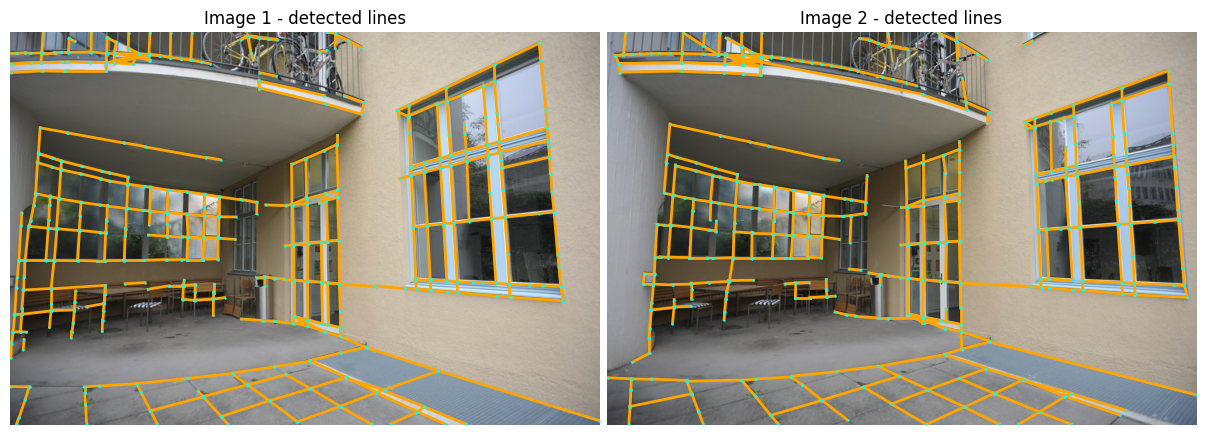

In [ ]:
imgs_to_plot = [K.tensor_to_image(torch_img1), K.tensor_to_image(torch_img2)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

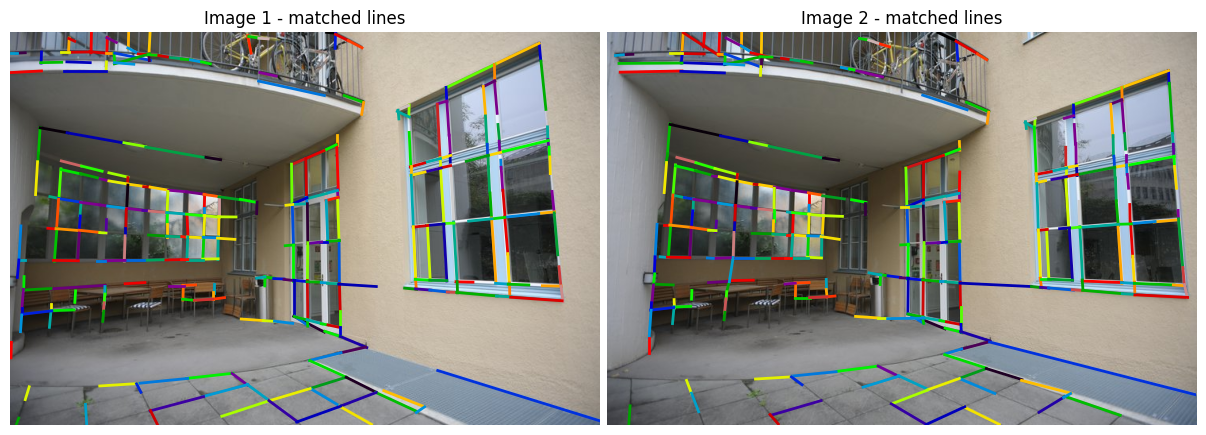

In [ ]:
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)

## Example of homography from line segment correspondences from SOLD2

Robust geometry estimation with Random sample consensus (RANSAC)

Load the model:

In [ ]:
ransac = K.geometry.RANSAC(model_type="homography_from_linesegments", inl_th=3.0)

### Perform the model correspondencies

In [ ]:
H_ransac, correspondence_mask = ransac(matched_lines1.flip(dims=(2,)), matched_lines2.flip(dims=(2,)))

Wrap the image 1 to image 2

In [ ]:
img1_warp_to2 = K.geometry.warp_perspective(torch_img1, H_ransac[None], (torch_img1.shape[-2:]))

### Plot the matched lines and wrapped image

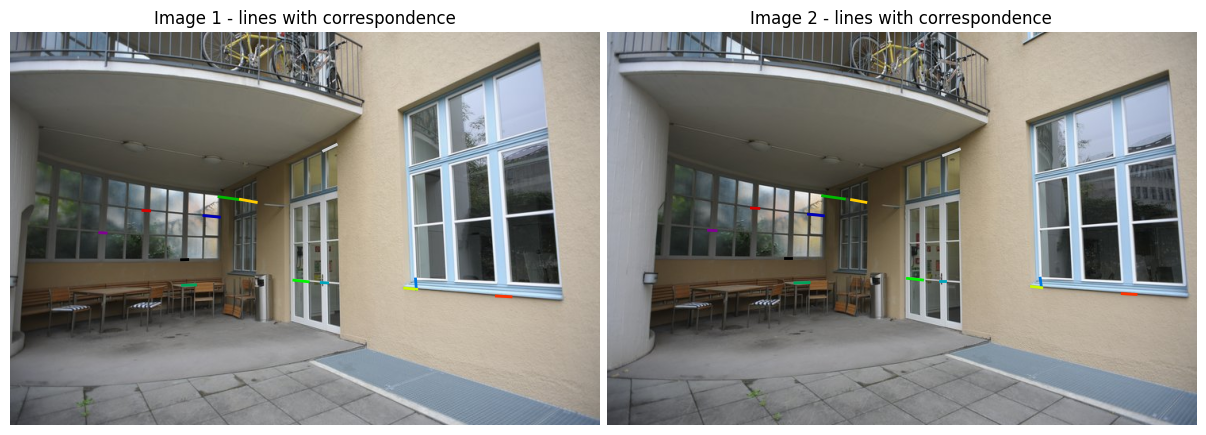

In [ ]:
plot_images(
    imgs_to_plot,
    ["Image 1 - lines with correspondence", "Image 2 - lines with correspondence"],
)
plot_color_line_matches([matched_lines1[correspondence_mask], matched_lines2[correspondence_mask]], lw=2)

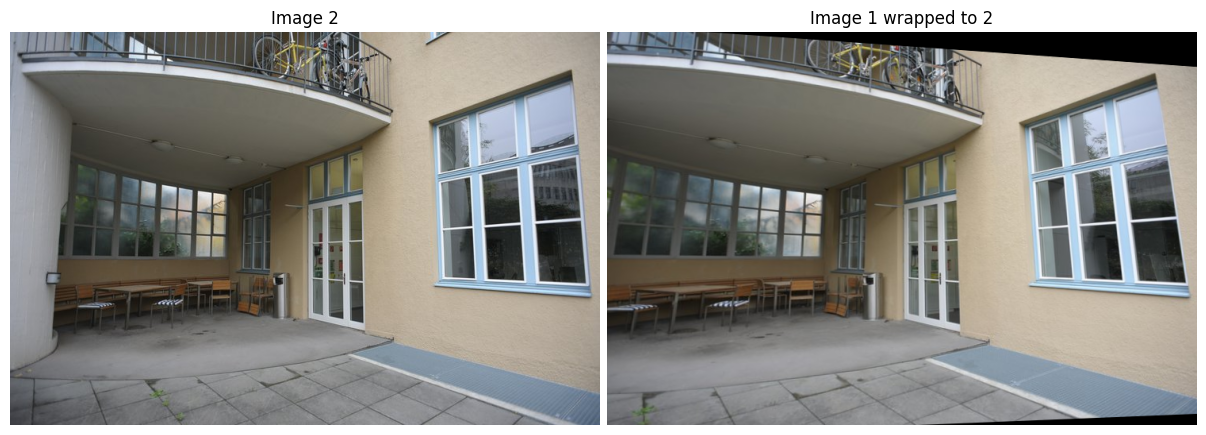

In [ ]:
plot_images(
    [K.tensor_to_image(torch_img2), K.tensor_to_image(img1_warp_to2)],
    ["Image 2", "Image 1 wrapped to 2"],
)